<a href="https://colab.research.google.com/github/rohithmn01/prom_forecast/blob/main/facebook_prophet_new_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
import pickle

In [3]:
class ProphetForecast:
    def __init__(self, train, test):
        self.train = train
        self.test = test

    def fit_model(self, n_predict):
        m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
        m.fit(self.train)
        future = m.make_future_dataframe(periods= len(self.test),freq= '1MIN')
        self.forecast = m.predict(future)

        return self.forecast

    def graph(self):
        fig = plt.figure(figsize=(40,10))
        plt.plot(np.array(self.train["ds"]), np.array(self.train["y"]),'b', label="train", linewidth=3)
        plt.plot(np.array(self.test["ds"]), np.array(self.test["y"]), 'g', label="test", linewidth=3)

        forecast_ds = np.array(self.forecast["ds"])
        plt.plot(forecast_ds, np.array(self.forecast["yhat"]), 'o', label="yhat", linewidth=3)
        plt.plot(forecast_ds, np.array(self.forecast["yhat_upper"]), 'y', label="yhat_upper", linewidth=3)
        plt.plot(forecast_ds, np.array(self.forecast["yhat_lower"]), 'y', label="yhat_lower", linewidth=3)
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend(loc=1)
        plt.title("Prophet Model Forecast")
        plt.show()

In [4]:
!pip3 install prophet
from prophet import Prophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 179 kB 10.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639426 sha256=20471c12b29adc80e5e4487e208769db9dfc84fd0aeff356a57f88ddcd47a5d9
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [5]:
def calc_delta(vals):
    diff = vals - np.roll(vals, 1)
    diff[0] = 0
    return diff

def monotonically_inc(vals):
    # check corner case
    if len(vals) == 1:
        return True
    diff = calc_delta(vals)
    diff[np.where(vals == 0)] = 0

    if ((diff < 0).sum() == 0):
        return True
    else:
        return False

In [7]:
from google.colab import files
uploaded = files.upload()


Saving prometheus_target_sync_length_seconds.pkl to prometheus_target_sync_length_seconds.pkl


In [8]:
pkl_file = open("prometheus_target_sync_length_seconds.pkl", "rb")
dfs = pickle.load(pkl_file)
pkl_file.close()
key_vals = list(dfs.keys())

In [9]:
print(key_vals)

["{'__name__': 'prometheus_target_sync_length_seconds', 'instance': '10.56.2.6:9090', 'job': 'kubernetes-service-endpoints', 'kubernetes_name': 'prometheus-service', 'kubernetes_namespace': 'monitoring', 'quantile': '0.01', 'scrape_job': 'kube-state-metrics'}", "{'__name__': 'prometheus_target_sync_length_seconds', 'instance': '10.56.2.6:9090', 'job': 'kubernetes-service-endpoints', 'kubernetes_name': 'prometheus-service', 'kubernetes_namespace': 'monitoring', 'quantile': '0.01', 'scrape_job': 'kubernetes-apiservers'}", "{'__name__': 'prometheus_target_sync_length_seconds', 'instance': '10.56.2.6:9090', 'job': 'kubernetes-service-endpoints', 'kubernetes_name': 'prometheus-service', 'kubernetes_namespace': 'monitoring', 'quantile': '0.01', 'scrape_job': 'kubernetes-cadvisor'}", "{'__name__': 'prometheus_target_sync_length_seconds', 'instance': '10.56.2.6:9090', 'job': 'kubernetes-service-endpoints', 'kubernetes_name': 'prometheus-service', 'kubernetes_namespace': 'monitoring', 'quantile

INFO:prophet:n_changepoints greater than number of observations. Using 13.


                             ds     trend  ...  multiplicative_terms_upper      yhat
0 2021-08-10 05:00:10.435000064  0.000761  ...                         0.0  0.000761
1 2021-08-10 05:00:24.435000064  0.000753  ...                         0.0  0.000753
2 2021-08-10 05:00:38.435000064  0.000745  ...                         0.0  0.000745
3 2021-08-10 05:00:52.435000064  0.000744  ...                         0.0  0.000744
4 2021-08-10 05:01:06.435000064  0.000745  ...                         0.0  0.000745

[5 rows x 13 columns]


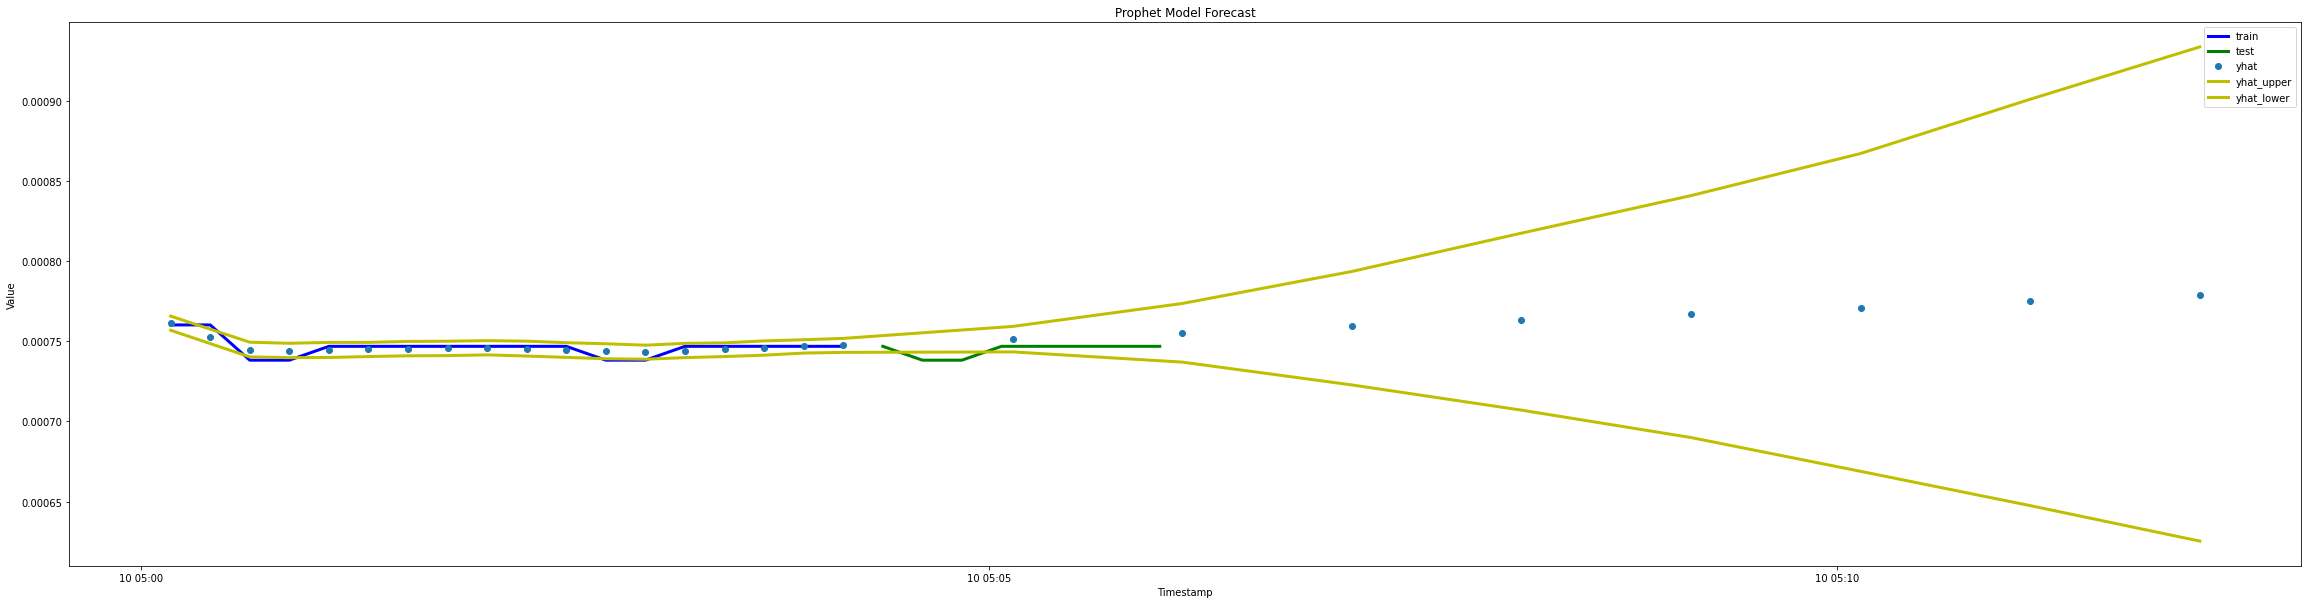

In [13]:

key = key_vals[4]
df = dfs[key]
df = df.sort_values(by=['ds'])
df["y"] = df["y"].apply(pd.to_numeric)

vals = np.array(df["y"].tolist())
    # check if metric is a counter, if so, run AD on difference
if monotonically_inc(vals):
    print("monotonically_inc")
    vals = calc_delta(vals)
    df["values"] = vals.tolist()

train = df[0:int(0.7*len(vals))]
test = df[int(0.7*len(vals)):]

pf = ProphetForecast(train, test)
forecast = pf.fit_model(len(test))
print(forecast.head())

pf.graph()